In [98]:
import tensorflow as tf
import pandas as pd
import os
from fast_ml.model_development import train_valid_test_split
from imblearn.combine import SMOTETomek
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, f1_score, confusion_matrix

%matplotlib inline
sns.set()

In [99]:
# Set memory limiter for each GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

In [100]:
data_path = os.path.join("dataset", "GGU_classification.csv")
data_df = pd.read_csv(data_path)

In [101]:
data_df.sample(3)

,label,price,est_meters,trip_duration,est_duration,wait_sec,service_taxi,service_uberblack,service_uberx,service_uberxl,country_colombia,country_equador,country_mexico
35137,0,1.0,4,78,0,80,1,0,0,0,0,0,1
27283,0,0.5,698,410,62,239,1,0,0,0,0,1,0
7086,1,5.1,9592,826,863,150,1,0,0,0,0,1,0


In [102]:
data_df["label"].value_counts()

0    34210
1     8163
Name: label, dtype: int64

In [103]:
scaled_df = data_df
scaler = MinMaxScaler()
scaled_df[["price", "est_meters", "est_duration", "trip_duration", "wait_sec"]] = scaler.fit_transform(scaled_df[["price", "est_meters", "est_duration", "trip_duration", "wait_sec"]])

In [104]:
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(scaled_df, target = 'label', 
                                                                            train_size=0.8, valid_size=0.1, test_size=0.1, random_state=42)

In [105]:
# oversampling to handle label imbalance
oversample = SMOTETomek(random_state = 42)
X_train_sm, y_train_sm = oversample.fit_resample(X_train, y_train)
X_valid_sm, y_valid_sm = oversample.fit_resample(X_valid, y_valid)

In [106]:
# check label counts
y_train_sm.value_counts()

0    27216
1    27216
Name: label, dtype: int64

In [107]:
X_train_sm.shape

(54432, 12)

In [108]:
csv_log = tf.keras.callbacks.CSVLogger(
    os.path.join("models", "history.csv"), 
    separator=",", 
    append=False
)

earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=2,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

In [109]:
KR = tf.keras.regularizers.L2(
    l2=0.00001
)
#LeakyReLU
model = tf.keras.models.Sequential([
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dense(300, input_shape=(12, ), activation="LeakyReLU", kernel_regularizer=KR),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(150, activation="LeakyReLU", kernel_regularizer=KR),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="sigmoid", kernel_regularizer=KR)
])

In [110]:
model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss="binary_crossentropy",
    metrics = ["accuracy"]
)

In [111]:
history = model.fit(
    X_train_sm, y_train_sm,
    validation_data = (X_valid_sm, y_valid_sm),
    batch_size=32,
    validation_batch_size=16,
    epochs=100, 
    verbose = 1,
    callbacks = [earlystop, csv_log]
)

Epoch 1/100
1701/1701 [==============================] - 21s 12ms/step - loss: 0.5405 - accuracy: 0.7704 - val_loss: 0.3817 - val_accuracy: 0.9149
Epoch 2/100
1701/1701 [==============================] - 21s 12ms/step - loss: 0.3298 - accuracy: 0.9066 - val_loss: 0.2698 - val_accuracy: 0.9248
Epoch 3/100
1701/1701 [==============================] - 21s 12ms/step - loss: 0.2655 - accuracy: 0.9194 - val_loss: 0.2398 - val_accuracy: 0.9313
Epoch 4/100
1701/1701 [==============================] - 21s 13ms/step - loss: 0.2417 - accuracy: 0.9238 - val_loss: 0.2239 - val_accuracy: 0.9340
Epoch 5/100
1701/1701 [==============================] - 22s 13ms/step - loss: 0.2273 - accuracy: 0.9268 - val_loss: 0.2121 - val_accuracy: 0.9352
Epoch 6/100
1701/1701 [==============================] - 21s 12ms/step - loss: 0.2180 - accuracy: 0.9283 - val_loss: 0.2035 - val_accuracy: 0.9356
Epoch 7/100
1701/1701 [==============================] - 23s 13ms/step - loss: 0.2100 - accuracy: 0.9305 - val_loss: 0

#### Analyze the result

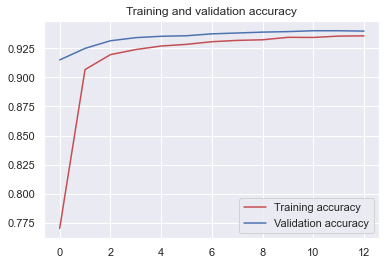

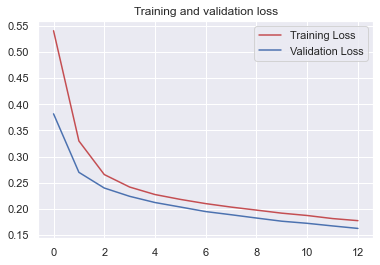

In [112]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [113]:
val_pred = model.predict(X_valid)
val_result = []
for pred in val_pred :
    if pred > 0.5 :
        val_result.append(1)
    else :
        val_result.append(0)

133/133 [==============================] - 0s 3ms/step


In [114]:
f1 = f1_score(list(y_valid), val_result)
print(f1 * 100)

80.44747081712063


<AxesSubplot:>

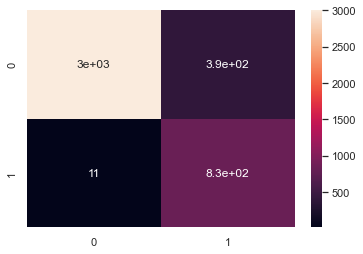

In [115]:
cm = confusion_matrix(list(y_valid), val_result)
sns.heatmap(cm, annot=True)

In [116]:
print(classification_report(list(y_valid), val_result, target_names=["0", "1"]))

              precision    recall  f1-score   support

           0       1.00      0.88      0.94      3399
           1       0.68      0.99      0.80       838

    accuracy                           0.91      4237
   macro avg       0.84      0.94      0.87      4237
weighted avg       0.93      0.91      0.91      4237



In [122]:
test_pred = model.predict(X_test)
test_result = []
for pred in test_pred :
    if pred > 0.5 :
        test_result.append(1)
    else :
        test_result.append(0)


133/133 [==============================] - 0s 3ms/step


In [123]:
len(test_result)

4238

In [134]:
model.save(os.path.join("models", "GGU_3_Classification.h5"))

In [135]:
test_df = pd.DataFrame({"label" : test_result})
test_report = pd.concat([X_test.reset_index(), test_df], axis=1, ignore_index=True)
test_report.to_csv(os.path.join("assets", "GGU_classification_report.csv"))

In [136]:
!jupyter-nbconvert --to PDFviaHTML classification_model.ipynb

[NbConvertApp] Converting notebook classification_model.ipynb to PDFviaHTML
[NbConvertApp] Writing 325665 bytes to classification_model.pdf
